# Deep Learning Scorer Simple CNN
Want to create a deep learning model that will read a review, and then spit out a score.
I don't expect this to work well, because as we've seen, the data seems to be very messy. But maybe we'll be able to extract some insight

Can probably just use some of the numbers that I start with, along with adding in a corpus and some frequency thing, at least as a start

Should try both a CNN and a LSTM, compare their performance on real data, and on the generated data

Oh, I might even find a way to transfer gpt-2 over and test it out on scoring. Could see about adding a different output layer to it (and maybe input if necessary).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as k
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
import spacy
import nltk
import en_core_web_md

Using TensorFlow backend.


In [2]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

In [3]:
ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
0,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
1,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
2,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
3,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
4,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587
5,https://www.ign.com/articles/2011/07/21/pixel-...,"\u003csection class=\""article-page\""\u003e\u00...",'Pixel Racer from 'Daily App Dream has a ...,"""Pixel Racer is not devoid of enjoyment. It wa...",5.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:14:23+0000,2011-07-21T23:53:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, pi...","[ign, wireless, ]","""Pixel Racer Review""",pixel racer from daily app dream has a fe...,5.5,2066,409,0.057118,0.422669
6,https://www.ign.com/articles/2011/07/22/world-...,"\u003csection class=\""article-page\""\u003eIf y...",If you're not familiar with Wargaming.net's f...,"""World of Tanks might have a silly name, but i...",7.5,":[""review"",""blogroll"",""legacy"",""pc-games"",""gam...",":[""ign"",""pc""],",2011-10-18T06:15:45+0000,2011-07-22T02:49:00+0000,"""Nick Kolan""","[review, bl

In [4]:
print(ign_df.shape)
ign_df.head()

(11072, 19)


,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
1,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
2,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
3,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
4,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
5,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587


In [5]:
# min/max_df are document frequency
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
# make it a OHE with 100 places (or 10, depending on model)
# oh, or I could put this between 0 and 1 and scale it, but that seems bad for a sigmoid
# maybe the score could be a reflection of if it's recommended to play it (I like this idea a lot)
ign_scores = ign_df['review_score_float'].values 

# may not end up using this
# word_vec_data = vectorizer.fit_transform(ign_data)

# need to vectorize and ohe data after splitting it
data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_scores, 
                                                                                test_size=test_size)

In [6]:
score_space = np.linspace(start=0.0,stop=10.0, num=101)
temp_values = [[round(x, 2)] for x in score_space]
# temp_values = [[str(round(x, 2))] for x in score_space]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(temp_values)
# print(enc.transform([[0.0], [0.3], [1.5]]).toarray())
ign_score_format = [[round(x, 2)] for x in ign_scores]
# ign_score_format = [[x] for x in ign_scores]
ign_targets = enc.transform(ign_score_format)

In [7]:
# creating one hot encoding
train_target_format = [[round(x, 2)] for x in target_train]
valid_target_format = [[round(x, 2)] for x in target_validation]

target_train_ohe = enc.transform(train_target_format)
target_valid_ohe = enc.transform(valid_target_format)

print(target_train_ohe.shape)
print(target_valid_ohe.shape)

(8857, 101)
(2215, 101)


In [8]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

# Above is some data transformation, some of which is unnecessary
Below is beginning of DL models

In [9]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2211, 4437]


In [10]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])
# print(vectorizer.get_feature_names())
# print(vectorizer.build_tokenizer())

[5000 5000 5000 ... 1413 3631 4947]


In [14]:
def simple_conv_model():
    
    model = Sequential()
    
    model.add(Embedding(len(vectorizer.get_feature_names()) +1, 
                        64, input_length=MAX_SEQ_LENGTH))
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(5, padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(5, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=101, activation='softmax'))
    
    return model

sim_conv_model = simple_conv_model()

sim_conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(sim_conv_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2700, 64)          320064    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2700, 64)          20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 540, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 540, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 540, 64)           20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 108, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6912)             

In [15]:
sim_conv_model.fit(data_train_sequences[:-100], target_train_ohe[:-100], 
                   epochs=100, batch_size=512, verbose=1, 
                   validation_data=(data_train_sequences[-100:], target_train_ohe[-100:]))

Train on 8757 samples, validate on 100 samples
Epoch 1/100
8757/8757 [==============================] - ETA: 5s - loss: 4.6126 - accuracy: 0.00 - ETA: 3s - loss: 4.5810 - accuracy: 0.02 - ETA: 2s - loss: 4.5386 - accuracy: 0.03 - ETA: 2s - loss: 4.4841 - accuracy: 0.03 - ETA: 1s - loss: 4.4246 - accuracy: 0.03 - ETA: 1s - loss: 4.3868 - accuracy: 0.04 - ETA: 1s - loss: 4.3517 - accuracy: 0.04 - ETA: 1s - loss: 4.3244 - accuracy: 0.04 - ETA: 1s - loss: 4.2905 - accuracy: 0.05 - ETA: 1s - loss: 4.2562 - accuracy: 0.05 - ETA: 0s - loss: 4.2336 - accuracy: 0.06 - ETA: 0s - loss: 4.2130 - accuracy: 0.06 - ETA: 0s - loss: 4.1912 - accuracy: 0.06 - ETA: 0s - loss: 4.1696 - accuracy: 0.06 - ETA: 0s - loss: 4.1537 - accuracy: 0.07 - ETA: 0s - loss: 4.1407 - accuracy: 0.07 - ETA: 0s - loss: 4.1261 - accuracy: 0.07 - 2s 269us/step - loss: 4.1256 - accuracy: 0.0743 - val_loss: 3.9543 - val_accuracy: 0.1100
Epoch 2/100
8757/8757 [==============================] - ETA: 1s - loss: 3.7476 - accuracy: 

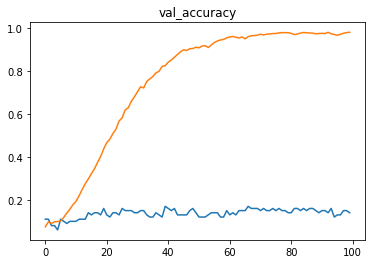

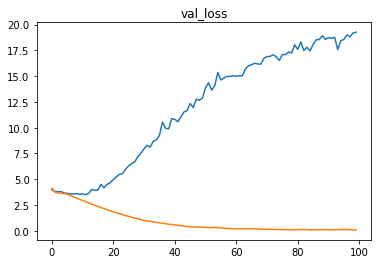

In [19]:
plt.plot(sim_conv_model.history.history['val_accuracy'])
plt.plot(sim_conv_model.history.history['accuracy'])
plt.title('val_accuracy')
plt.show()

plt.plot(sim_conv_model.history.history['val_loss'])
plt.plot(sim_conv_model.history.history['loss'])
plt.title('val_loss')
plt.show()

Well, this was an overly simple model, going to build an overly simple lstm now as well